# *WoMG*: tutorial

This is a tutorial for *WoMG*. The WoMG software generates synthetic datasets of documents cascades on network. It starts with any (un)directed, (un)weighted graph and a collection of documents and it outputs the propagation DAGs of the docs through the network. Diffusion process is guided by the nodes underlying preferences.


First section will introduce a demo of the software.

Second section will provide a basic usage with the [Digg](https://www.isi.edu/~lerman/downloads/digg2009.html) dataset used in the thesis. Digg dataset contains a network dataset and a propagation dataset.

The Analysis section will analyse the synthetic dataset of propagations generated by WoMG using the Digg network as input graph; the real propagation values are reported at the end of the previous section. 

The statistics section is used for simulating different propagations with different parameters and plotting the results; this kind of statistics needs lot of computation by WoMG, so synthetic datasets are already produced.

### TOC:
* [Demo](#Demo)
* [Help](#Help)
* [Usage](#Usage)
* [Analysis](#Analysis)
* [ESPERIMENTS](#ESPERIMENTS)

## Demo

WoMG can be used both in command line and Jupyter notebook. The following codes will run WoMG with the default parameters.

##### command line:

In [ ]:
#%run ../src/womg/__main__.py

##### Jupyter notebook:

In [4]:
import sys
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
path = pathlib.Path("../src")
sys.path.insert(0, str(path))
from womg.__main__ import womg_main

#womg_main(virality=2, gn_strength=0, numb_docs=30)

In [ ]:
#!ls

Checking the outputs

In [ ]:
#!cd ../Output/ ; ls ; pwd #cat Propagations0.txt cwd



## Help

Let's check the parameters by the help page:

In [ ]:
help(womg_main)

## Usage

The following code will produce a synthetic propagation dataset on the [Digg network dataset](https://www.isi.edu/~lerman/downloads/digg2009.html). This dataset consists in: graph dataset and diffusion dataset. We used the first as input of WoMG for generating diffusions and analyse results. 

We set:

1. the number of steps equal to 100
2. number of generated docs equal to 3553
3. virality exponent of the docs distribution equal to 0.009

In [ ]:
#!python3 ../src/womg/__main__.py --graph ../data/graph/lesmiserables/lesmiserables_edgelist.txt --topics 2 --homophily 0 --int_mode n2i --steps 100 --docs 3553  --virality 0.5

##### Output

The analysis of the actions using digg network as input can be done using simulation_index=_tutorial.

The real dataset analysis provides the following results:

    items actions [max, min, avg]:   6265 105 505

    users actions [max, min, avg]:   3415 20 115

## Analysis

Let's check the synthetic dataset results:

In [109]:
womg_main(numb_docs=20, virality=0.01, gn_strength=0, numb_topics=4)

100%|██████████| 77/77 [00:00<00:00, 190089.12it/s]

No graph path provided 
 DEMO Mode: generating cascades in les miserables network
Formatting graph:
Setting god node
Random generation of interests:
Setting LDA in generative mode:  20  documents, with  4  topics.
Training the LDA model ..



100%|██████████| 20/20 [00:00<00:00, 26247.21it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.


In [ ]:
#simulation_index = "2"
#output_path = pathlib.Path.cwd().parent / "Output"

In [ ]:
#file_prop = output_path / str("Propagations"+str(simulation_index)+".txt")
#file_topic = output_path / str("Topics_descript"+str(simulation_index)+".txt")

###### import functions

In [ ]:
#df = pd.read_csv(file_prop, sep=' ', names=['time', 'item', 'node'])
#df.head()

##### analysis functions

In [ ]:
#items_act = df.groupby('item').node.nunique()
#print(items_act.max(), round(items_act.mean(), 2), items_act.min())

In [ ]:
#users_act = df.groupby('node').item.nunique()
#print(users_act.max(), round(users_act.mean(), 2), users_act.min())

## ESPERIMENTS

In [2]:
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
path = pathlib.Path("../src")
sys.path.insert(0, str(path))
from __main__ import womg_main

In [100]:
topics = [10]
docs = [10]
steps = [100] 
beta = [0.1]
homophily = [-1, -0.5, 0, 0.5, 1]
virality = [0.01, 0.05]
god_node_strength = [0] 
influence_strength = [0] 

In [101]:
args_list = []

nr_experiments = 10 

for t in topics:
    for d in docs:
        for s in steps:
            for b in beta:
                for h in homophily:
                    for v in virality:
                        for g in god_node_strength:
                            for f in influence_strength:
                                for seed in range(nr_experiments):
                                    args = [t, d, s, b, h, v, g, f, seed]
                                    args_list.append(args)

In [102]:
path_out =  pathlib.Path.cwd().parent / "Simulation"
#graph_path = pathlib.Path.cwd().parent / str("data/graph/digg/digg_edgelist.txt")
graph_path = pathlib.Path.cwd().parent / str("data/graph/lesmiserables/lesmiserables_edgelist.txt")
#graph_path = pathlib.Path.cwd().parent / str("data/graph/wiki_vote/wiki_vote_edgelist.txt")
directed = False
int_mode = 'n2i'
norm_prior = True

In [103]:
def graph_analysis(graph_path):
    G = nx.read_edgelist(graph_path)
    print('avg clustering coeff ', nx.average_clustering(G))
    print('numb of connected components: ', (nx.number_connected_components(G)))
    print('numb of triangles: ', float(sum(nx.triangles(G).values()))/3)
    print('Assortativity: ', nx.degree_assortativity_coefficient(G))

    degree = np.array(list(dict(G.degree).values()))

    plt.figure(figsize=(9,7))
    plt.hist(degree, bins=100, normed=True)

    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel('Degree', fontsize=17)
    plt.ylabel('$P(k)$', fontsize=17)
    plt.show()

avg clustering coeff  0.5731367499320135
numb of connected components:  1
numb of triangles:  467.0
Assortativity:  -0.16522513442236916


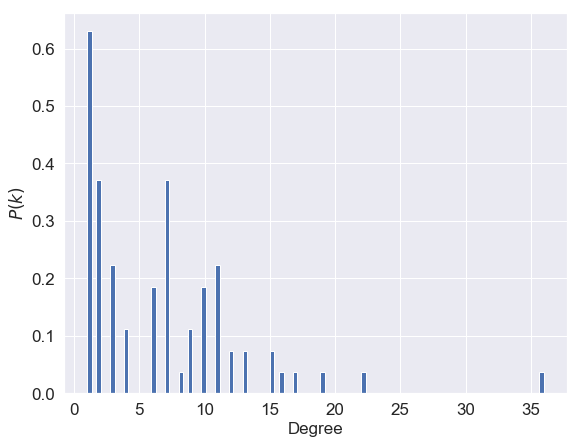

In [104]:
graph_analysis(graph_path)

In [105]:
from tqdm import tqdm_notebook

def experiment(args_list):
    for args in tqdm_notebook(args_list):
        t, d, s, b, h, v, g, f, seed = args
        womg_main(path_out=path_out, graph_path=graph_path,
                  directed=directed, int_mode=int_mode,
                  numb_topics=t, numb_docs=d, numb_steps=s, beta=b, 
                  homophily=h, virality=v, gn_strength=g, infl_strength=f,
                  seed=42*seed+(d+t)*8)

In [106]:
experiment(args_list)

HBox(children=(IntProgress(value=0), HTML(value='')))

100%|██████████| 77/77 [00:00<00:00, 174668.15it/s]

Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 182877.35it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 200597.15it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 182052.65it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 164189.84it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 181133.71it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 154600.96it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 151269.98it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 108449.10it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 221814.15it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 188866.32it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 170698.42it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 188755.94it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 161158.39it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 151482.84it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 151838.93it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 285049.79it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 171423.25it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 153644.82it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 171879.41it/s]

Computing cascades: 

 Simulation stopped at timestep  5 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 189642.64it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 187332.60it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 161400.00it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 199976.10it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 245225.06it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 142587.82it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 128823.86it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 160757.30it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 193390.06it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 253501.89it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 163111.82it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 122195.01it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 170698.42it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 254300.32it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 120688.12it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 162455.44it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 160119.69it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 175331.93it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 149588.42it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 203632.67it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 172614.33it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 194437.93it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 137723.41it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 183292.51it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 176481.64it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 197047.84it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 150354.47it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 157158.84it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 192468.06it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 152772.66it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 196568.11it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 171150.72it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 130016.67it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 208093.69it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 189198.25it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 89836.27it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 249198.62it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 267352.16it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 183292.51it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 188645.68it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 231845.95it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 250941.26it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 276982.34it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 164106.41it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 165282.19it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 152196.70it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 160358.20it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 183709.56it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 164524.41it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 171879.41it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 229865.77it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 176965.16it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 173448.66it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 101305.34it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 190089.12it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 191668.49it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 204276.67it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 165621.23it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 182877.35it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 161400.00it/s]

Computing cascades: 

 Simulation stopped at timestep  1 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 135356.83it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 221966.60it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 216898.19it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 190201.06it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 187768.26it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 186898.96it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 132578.57it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 169533.55it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 177451.32it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 187332.60it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 158159.36it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 191554.81it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 182155.33it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 139749.64it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 172706.64it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 225847.14it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 213881.73it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 192353.43it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 171514.29it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 77/77 [00:00<00:00, 191554.81it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.
Formatting graph:
Setting god node
Generating interests from graph in 


Setting LDA in generative mode:  10  documents, with  10  topics.
Training the LDA model ..


100%|██████████| 10/10 [00:00<00:00, 12752.52it/s]

Computing cascades: 

 Simulation stopped at timestep  0 
 Diffusion has been completed.



In [131]:
def isNaN(num):
    return num != num

def statistics(path):
    result = []
    for _ in range(len(args_list)):
        file_prop = path / str("Propagations"+str(_)+".txt")
        file_topic = path / str("Topics_descript"+str(_)+".txt")
        df = pd.read_csv(file_prop, sep=' ', names=['time', 'item', 'node'])
        mean_items_act = round(df.groupby('item').node.nunique().mean(), 2)
        mean_users_act = round(df.groupby('node').item.nunique().mean(), 2)
        #print(mean_items_act)
        result.append(args_list[_]+[mean_items_act, mean_users_act,])
    return result

In [132]:
stat = statistics(path_out)
df = pd.DataFrame(stat, columns=['t', 'd', 's', 'b', 'h', 'v', 'g', 'f', 'seed', 'mean_it_act', 'mean_us_act'])

In [133]:
df.head()

,t,d,s,b,h,v,g,f,seed,mean_it_act,mean_us_act
0,10,10,100,0.1,-1.0,0.01,0,0,0,NaN,NaN
1,10,10,100,0.1,-1.0,0.01,0,0,1,NaN,NaN
2,10,10,100,0.1,-1.0,0.01,0,0,2,NaN,NaN
3,10,10,100,0.1,-1.0,0.01,0,0,3,NaN,NaN
4,10,10,100,0.1,-1.0,0.01,0,0,4,NaN,NaN


In [135]:
# NaN values correspond to low virality 0.1
df[df.isnull().any(axis=1)].head()

,t,d,s,b,h,v,g,f,seed,mean_it_act,mean_us_act
0,10,10,100,0.1,-1.0,0.01,0,0,0,NaN,NaN
1,10,10,100,0.1,-1.0,0.01,0,0,1,NaN,NaN
2,10,10,100,0.1,-1.0,0.01,0,0,2,NaN,NaN
3,10,10,100,0.1,-1.0,0.01,0,0,3,NaN,NaN
4,10,10,100,0.1,-1.0,0.01,0,0,4,NaN,NaN


In [127]:
df = df.fillna(0)

In [128]:
# average items activations
df_i = df.groupby(['h', 'v'])['mean_it_act'].mean().unstack()
df_i

v,0.01,0.05
h,,
-1.0,0.0,5.4
-0.5,0.0,0.1
0.0,0.0,0.1
0.5,0.0,0.8
1.0,0.0,0.2


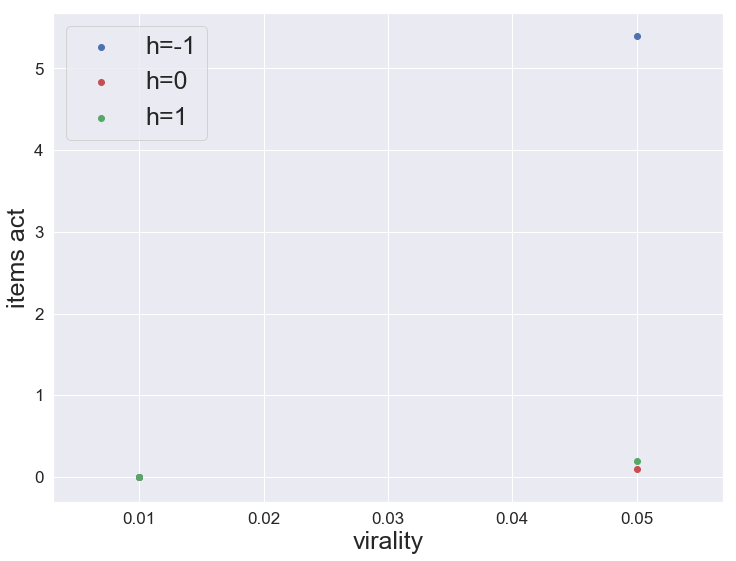

In [129]:
sns.set()
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)


ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[0], c='b', marker="o", label='h=-1')
ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[2],  c='r', marker="o", label='h=0')
ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[4],  c='g', marker="o", label='h=1')
ax1.legend(fontsize=25)
plt.xlabel('virality', fontsize=25)
plt.ylabel('items act', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

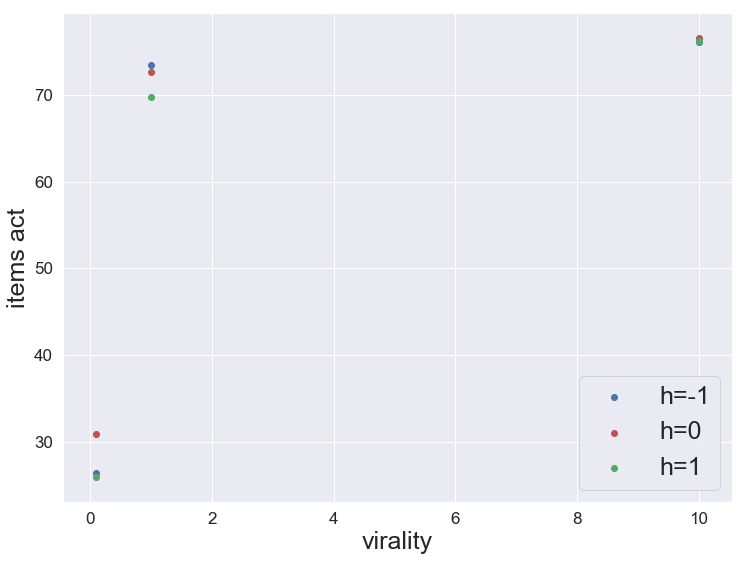

In [68]:
sns.set()
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)


ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[0], c='b', marker="o", label='h=-1')
ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[2],  c='r', marker="o", label='h=0')
ax1.scatter(x=df_i.iloc[0].index, y=df_i.iloc[4],  c='g', marker="o", label='h=1')
ax1.legend(fontsize=25)
plt.xlabel('virality', fontsize=25)
plt.ylabel('items act', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

In [ ]:
df_i.iloc[0]

In [ ]:
sns.set()
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)


ax1.scatter(x=df_i.index, y=df_i.iloc[0], c='b', marker="o", label='v=0.1')
ax1.scatter(x=df_i.index, y=df_i.iloc[1],  c='r', marker="o", label='v=1')
ax1.scatter(x=df_i.index, y=df_i.iloc[2],  c='g', marker="o", label='v=10')
ax1.legend(fontsize=25)
plt.xlabel('homophily', fontsize=25)
plt.ylabel('items act', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

In [ ]:
df_i.iloc[0].index

In [ ]:
# average users activations
df_u = df.groupby(['h', 'v'])['mean_us_act'].mean().unstack()
df_u.head()

In [ ]:
# cdf of simulation 0 - items activation

file_prop = path_out / str("Propagations"+str(0)+".txt")
file_topic = path_out / str("Topics_descript"+str(0)+".txt")
df = pd.read_csv(file_prop, sep=' ', names=['time', 'item', 'node'])
mean_items_act = round(df.groupby('item').node.nunique().mean(), 2)

#sns.distplot(df.groupby('item'), hist_kws={'cumulative' : True})
#plt.show()
miss = pd.Series([0 for _ in ['1','2','3','4','5','6','7','9']], index =['1','2','3','4','5','6','7','9'])
complete = df.groupby('item').node.nunique().append(miss)

In [ ]:
import seaborn as sns
sns.set()

plt.hist(complete, cumulative=True, normed=True)
plt.show()

In [ ]:
### virality plot
from tqdm import tqdm
import pathlib
path = pathlib.Path('../Output/')

file_idx = [i for i in range(len(viralities))]
#file_idx = [0, 1]

y_item = []
x_item = []
y_user = []
x_user = []
cdf_data = {}
cdf_data['item'] = {}
cdf_data['user'] = {}
for i in tqdm(file_idx):
    file_info = path / str("Network_info_sim"+str(i)+".txt")
    file_prop = path / str("Diffusion_formatted_output_sim"+str(i)+".txt")
    # data for cdf plot
    cdf_data['item'][i] = []
    cdf_data['user'][i] = []
    ########################
    info_str = extract(file_info)
    info = to_dict(info_str, typ=True)
    prop = extract(file_prop)
    cascades = to_dict(prop, typ=False)
    items_data = items_actions(cascades, plot=False)
    users_data = users_actions(cascades, info=info)
    for n in range(len(items_data)):
        cdf_data['item'][i].append(items_data[n])
        y_item.append(items_data[n])
        x_item.append(viralities[i])
    for n in range(len(users_data)):
        cdf_data['user'][i].append(users_data[n])
        y_user.append(users_data[n])
        x_user.append(viralities[i])

##### violin plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(15,11))

plt.xlabel('virality', fontsize=22)
plt.ylabel('items actions', fontsize=22)

ax = sns.violinplot(x=x_item, y=y_item)
sns.set()
plt.show()


#fig.savefig()

##### cdf plot

In [ ]:
fig = plt.figure(figsize=(15,11))


file_idx = [i for i in range(len(viralities))]


cdf_hist = {}
cdf_hist['user'] = {}
cdf_hist['item'] = {}
for i in [0, 1]:
    # evaluate the histogram
    cumulative = []
    values, base = np.histogram(cdf_data['item'][i], bins=50)
    cdf_hist['item'][i] = (values, base)
    
for i in [0, 1]:
    #evaluate the cumulative
    cumulative = np.cumsum(cdf_hist['item'][i][0])/3553
    # plot the cumulative function
    plt.plot(base[:-1], cumulative, linewidth=5)
    #print(cumulative)
    plt.xlabel('actions', fontsize=33)
    plt.ylabel('CDF', fontsize=33)
    plt.tick_params(labelsize=17)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.locator_params(axis='y', nbins=20)
    plt.locator_params(axis='x', nbins=20)
    plt.title('items CDF', fontsize=33)
    plt.legend(['virality-exp=2', 'virality-exp=0.1', 'virality-exp=0.11', 'virality-exp=0.45', 'virality-exp=0.45'], 
               fontsize=33)
plt.show()
#fig.savefig()